# Budowanie modeli
#### zespół budujący:
- Szymon Gut
- Jan Krężel

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

# Wczytanie wszystkich potrzebnych danych

In [33]:
urbanGB = pd.read_table("urbanGB.txt", sep=",")

In [34]:
urbanGB

,lng,lat
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594
...,...,...
360172,-0.557803,53.2197
360173,-1.748430,52.4872
360174,-0.128844,51.5126
360175,-1.885640,52.4490


Skalowanie dlugosci geograficznej aby obliczanie długości geograficznej miało ten sam sens co obliczanie odległości euklidesowej

urbanGB['lng'] = urbanGB['lng'].div(1.7) 

In [35]:
urbanGB_centr = pd.read_table("urbanGB.centr.txt", sep=",")

In [36]:
urbanGB_centr

,longtitude,lattitude
0,-0.141365,51.5039
1,-2.934580,53.4234
2,-3.544380,55.8940
3,-1.857930,52.4706
4,-4.630890,53.3077
...,...,...
464,-1.742190,54.8668
465,-0.644559,50.8336
466,-0.971466,51.7464
467,-2.801070,55.6144


In [37]:
urbanGB_labels = pd.read_table("urbanGB.labels.txt", sep=",")

In [38]:
urbanGB_labels

,idx_from_urb_centr
0,53
1,280
2,1
3,1
4,267
...,...
360172,122
360173,4
360174,1
360175,4


# Przedstawienie graficzne miejsc w których wystęowały wypadki

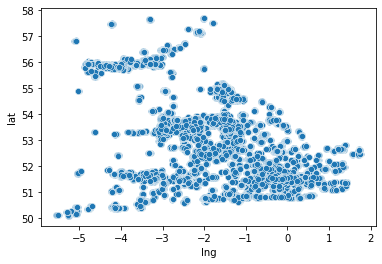

In [61]:
sns.scatterplot(data=urbanGB, x='lng', y='lat',palette=sns.color_palette("coolwarm", as_cmap=True))
plt.show()

In [73]:
samples = urbanGB.to_numpy()

In [84]:
def seq(start, end, by = None, length_out = None):
    len_provided = True if (length_out is not None) else False
    by_provided = True if (by is not None) else False
    if (not by_provided) & (not len_provided):
        raise ValueError('At least by or n_points must be provided')
    width = end - start
    eps = pow(10.0, -14)
    if by_provided:
        if (abs(by) < eps):
            raise ValueError('by must be non-zero.')
    #Switch direction in case in start and end seems to have been switched (use sign of by to decide this behaviour)
        if start > end and by > 0:
            e = start
            start = end
            end = e
        elif start < end and by < 0:
            e = end
            end = start
            start = e
        absby = abs(by)
        if absby - width < eps: 
            length_out = int(width / absby)
        else: 
            #by is too great, we assume by is actually length_out
            length_out = int(by)
            by = width / (by - 1)
    else:
        length_out = int(length_out)
        by = width / (length_out - 1) 
    out = [float(start)]*length_out
    for i in range(1, length_out):
        out[i] += by * i
    if abs(start + by * length_out - end) < eps:
        out.append(end)
    return out

In [95]:
ks=seq(6,30, by = 2)
ks = [int(i) for i in ks]
ks

[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

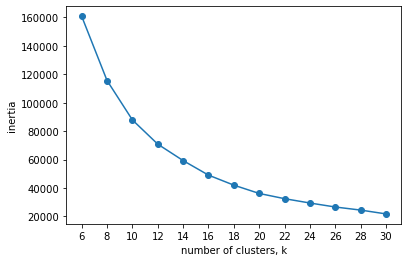

In [93]:
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    
    model.fit(samples)

    inertias.append(model.inertia_)
 
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [100]:
ks=seq(6,60, by = 5)
ks = [int(i) for i in ks]
ks

[6, 11, 16, 21, 26, 31, 36, 41, 46, 51]

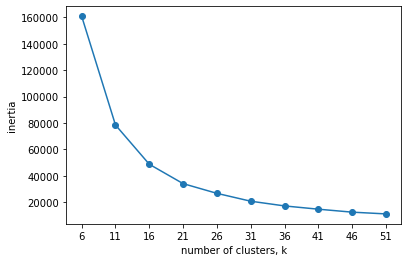

In [101]:
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    
    model.fit(samples)

    inertias.append(model.inertia_)
 
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


Na wykresie możemy zobaczyć jak liczba klastrów wpływa na dokładność przybliżania naszych danych centroidami. Im mniejsza `inertia` tym nasze dane są bliżej centroidów. Jednak przy wyborze optymalnego modelu należy również zwrócić uwagę na liczbę klastrów. Dobry model to taki, który przy minimalnej liczbie klastrów osiąga niską `inerpia'e`. Zatem przy wyborze naszego modelu posłużymy się `elbow's method`, czyli wybierzemy ten model dla którego spadek na wykresię staje się nagle łagodniejszy

**patrząc na te dwa wykresy słusznym kandydatem na liczbę klastrów wydaje się 21. Jest to ilość, która dostatecznie minimalizuje nam `inertia'e` oraz możemy zauważyć, że większe liczby klastrów tylko nieznacznie poprawiają nam wyniki**

TODO: Inna klastwryzacja